# 인공지능으로 세상에 없던 새로운 패션 만들기
## 프로젝트 : CIFAR-10 이미지 생성하기
학습 목표
생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기

Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기

Fashion MNIST 데이터셋의 의미를 알기

생성적 적대 신경망(GAN)의 구조와 원리를 이해하기

텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기

FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

### STEP 1. 작업환경 구성하기

프로젝트를 진행하는 데에 필요한 모든 패키지를 불러오고 시작하도록 하자

신경망 구성에 필요한 텐서플로우를 포함해서, 이미지와 GIF를 다루는 데 쓰이는 imageio, display, matplotlib, PIL 등 여러 가지 패키지가 필요합니다.

**Cloud Shell 에서 입력해야한다.**

```
$ pip list | grep -E 'imageio|Pillow'
```

**imageio, pillow 라이브러리 설치**

```
$ pip install imageio
$ pip install Pillow
```

**작업환경 구성**

```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


### STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.

로드한 학습 데이터를 시각화를 통해 확인해 봅시다.

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

tf.keras 안에 있는 datasets에서 불러와서 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

pixel 최대 최소값 확인하기

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


이미지라서 0~255 사이 값으로 이루어져 있음

이미지를 [-1, 1]로 정규화합니다.

이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.

In [4]:
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", train_x.max()) 
print("min pixel:", train_x.min()) 

max pixel: 1.0
min pixel: -1.0


데이터셋 shape 확인

In [5]:
train_x.shape

(50000, 32, 32, 3)

딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요한데 예제해서 했던 fashion_mnist와 다르게 채널수에 대한 차원이 나타나서 reshape할 필요 없어보인다. 위에 말했던 fashion_mnist와 cifar10에 차이점은 이미지 크기가 32x32인것과 채널수 3임

In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')

첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


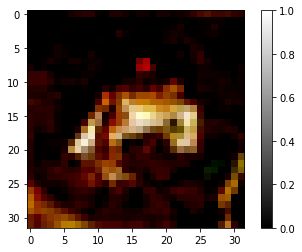

In [7]:
plt.imshow(train_x[0].reshape(32, 32, 3), cmap='gray') # plt.imshow(train_x[i].reshape(32, 32, 3), cmap='gray')
plt.colorbar()
plt.show()

예제에서는 채널값 안주고 28x28만 줘도 나왔었는데 여기선 채널값 3을 안주니까 오류나옴

for 문을 활용하여 10개 나타내기

여러개 한 번에 띄우고 싶을 때 plt.subplot(row, col, index)의 형태로 볼 수 있다. index는 1부터 10까지 순서대로 바뀌어야 하니 for문에서 사용하는 i에 1을 i+1을 넣어주면 됨

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

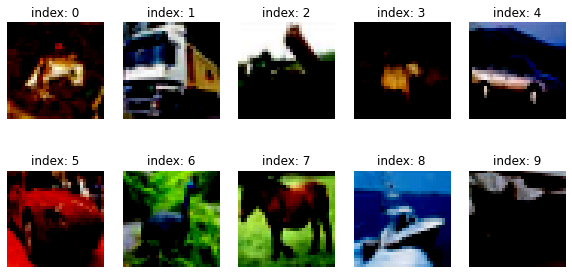

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1) # 
    plt.imshow(train_x[i].reshape(32, 32, 3)) # plt.imshow(train_x[i].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {i}') # 이미지 제목에 라벨 값 넣어줌
    plt.axis('off') # 불필요한 축 지움
plt.show()

for 문을 활용해서 이미지 25개를 5x5 의 배열로 띄워보세요. 단, 모든 이미지는 train_images에서 랜덤으로 추출해 보세요.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

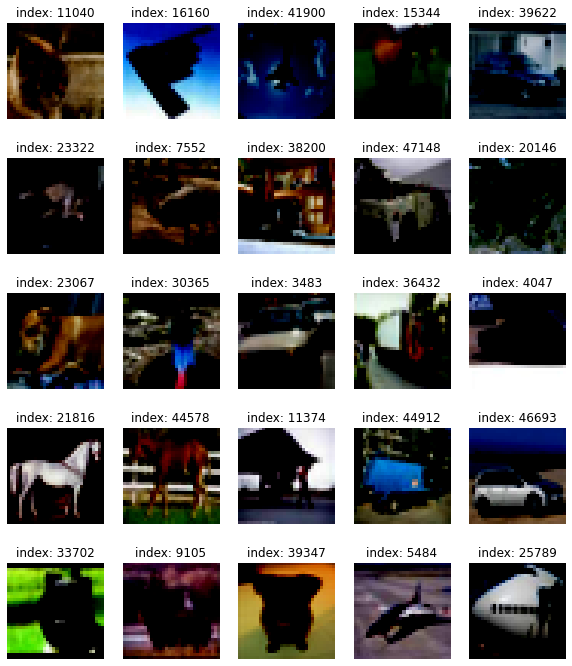

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000) # # numpy에서 랜덤으로 정수를 추출해 주는 함수 : randint
    plt.imshow(train_x[random_index].reshape(32, 32, 3)) 
    # plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
# BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정합니다. 
BUFFER_SIZE = 50000
BATCH_SIZE = 256

미니 배치 학습
BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양이다. 많은 양을 한 번에 학습시키면 메모리 활용 면에서 비효율적이고,학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행힌다.

shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다. 
위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.

noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.

생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 할수있다.

In [12]:
def make_generator_model(): 


    # Start
    model = tf.keras.Sequential() #tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓아줍니다.
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다.
    model.add(layers.LeakyReLU()) # 중간층들의 활성화 함수는 모두 LeakyReLU를 사용하였습니다.

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer


    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    # 마지막 층은 활성화 함수로 tanh를 사용한다, 이는 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

    return model

model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU()) 

model.add(layers.Reshape((8, 8, 256)))
    
이부분에서 8부분이 예제에서 7이었는데 7로 모델링하니까 셰이프가 32, 32가 안나와서 8로 하니까 제대로 나오던데 왜그런지 잘 모르겠음
어쨌든 8로 하니까 모양이 제대로 나오는걸 확인할수 있었다

In [13]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력해 봅시다.
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있습니다.

noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈 만들기

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
# 단, 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다! 
# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 
# training=False을 주어야 올바른 결과를 얻을 수 있습니다.
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


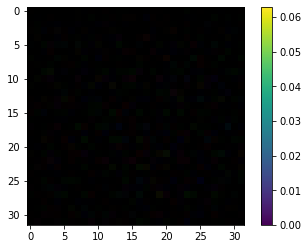

In [16]:
# 이미지 시각화 하기
plt.imshow(generated_image[0])  # 이렇게 하니까 여러색깔 나오는데?
# plt.imshow(generated_image[0, :, :, 0], cmap='gray') # 이렇게 하면 흑백
# plt.imshow(generated_image[0, :, :, 0]) # 이렇게 하면 초록색 되는데..
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.

위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [17]:
def make_discriminator_model(): # 판별자 또한 make_discriminator_model 함수로 구현

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3])) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())
    # Flatten은 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 

    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    # 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.
    return model

input_shape=[28, 28, 1]) 에서 input_shape=[32, 32, 3]으로 바꿈

In [18]:
# 판별 모델을 discriminator라는 변수 이름으로 생성, 모델 세부 내용인 summary를 출력해 봅시다.
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00091748]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.

판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.

생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
# generator_loss는 다음과 같이 구현
# generator_loss는 fake_output가 1에 가까워지기를 바라므로, 
# 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
# 즉, cross_entropy(tf.ones_like(fake_output), 
# fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
# 반면, discriminator_loss는 real_output 값은 1에 가까워지기를, 
# fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. 
# real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!
# 최종 discriminator_loss 값은 이 둘을 더한 값입니다.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.

training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터 : Real Image 역할을 할 images 한 세트를 입력으로 받음
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  
    #(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
        #(3) tf.GradientTape() 오픈 : 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
        generated_images = generator(noise, training=True)  
        #(4) generated_images 생성 :generator가 noise를 입력받은 후 generated_images 생성

        #(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 
        # real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #(10) 리턴값 ; 이번 스텝에 계산된 loss와 accuracy를 리턴
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  

# 이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.

In [27]:
# 그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 
# 볼 수 있는 샘플을 생성하는 함수를 만들어 보죠.
# 아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 
# 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i]) # plt.imshow(predictions[i]) 이렇게 해서 색을 새로 지정해주는거같음
        # plt.imshow(predictions[i, :, :, 0], cmap='gray') # 이때는 흑백으로만 나왔음
        # plt.imshow(predictions[i, :, :, 0] # 이 코드였을때는 초록색으로만 나옴
        # plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8')) # 정규화 전으로 변환 이렇게 해도 된다고함
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.

학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 400

In [32]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

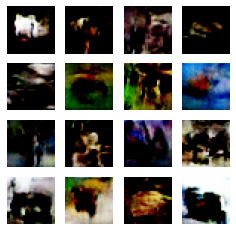

Time for training : 6558 sec


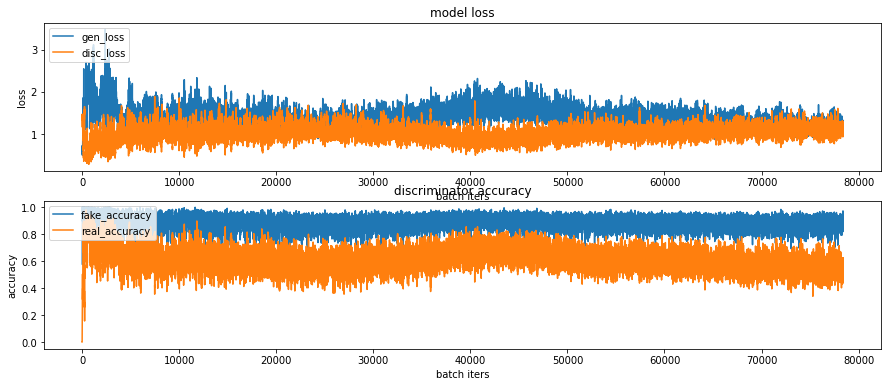

CPU times: user 1h 57min 45s, sys: 11min 28s, total: 2h 9min 13s
Wall time: 1h 49min 23s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

In [34]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 2210019 Feb 15 13:42 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


처음에 500번 돌려봄 점점 칼라로 나오는가 했는데 그게 아니고 그냥 흑백이었음

![fashion_mnist_dcgan (1)](https://user-images.githubusercontent.com/97030342/154074191-15408f62-f9c5-42e2-81bf-0ef088a39e8e.gif)

칼라맵에서 gray라서 흑백으로 나오는것으로 생각했기때문에 칼라맵 부분 없앰 그랬더니 초록색으로만 나왔음 근데 검은색 부분도 같이 나옴

![fashion_mnist_dcgan (2)](https://user-images.githubusercontent.com/97030342/154074286-c0c7b087-0e3d-4d3c-8f40-165bc6e5233b.gif)

학습 진행과정 부분에서 잘못되어있다는 걸 알고 수정했더니 다양한 색깔을 나타냄 하지만 전과정들이 다 노출되고 있음

![fashion_mnist_dcgan (3)](https://user-images.githubusercontent.com/97030342/154074300-20a2c97a-bd35-40f9-88fe-9d511fcdd9b3.gif)

체크포인트에 다 저장 되어있다고 판단해서 체크포인트에 있는걸 다 지웠지만 그래도 계속 전과정들이 출력됨

![fashion_mnist_dcgan (4)](https://user-images.githubusercontent.com/97030342/154074328-348051bf-51bc-48f7-ada0-5afc8c46ee6f.gif)

generated_samples이랑 training_checkpoints, training_history 다지워봄 다 지웠더니 앞에거 다 날아가고 방금 돌린거만 나왔음
여긴 에포크 50만 돌림

![fashion_mnist_dcgan (5)](https://user-images.githubusercontent.com/97030342/154074716-096215c4-757a-4704-adaa-5ee75ccd3fa2.gif)

에포크 400으로 키워서 돌려봄 위에보다 괜찮게 나오긴 하지만 400을 돌렸는데도 불구하고 이미지에 제대로된 모습을 파악하기는 힘듬

![fashion_mnist_dcgan (6)](https://user-images.githubusercontent.com/97030342/154074744-31afd3b6-15d6-4dc6-b0d4-fdb8002f9dc8.gif)

### STEP 8. (optional) GAN 훈련 과정 개선하기

STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.

모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

**[How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)**

**[10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)**

**[Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)**

**[Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)**

## 회고

STEP을 6을 진행할때 처음에 노드에서 배운대로 했더니 cmap='gray'라서 그런지 흑백으로 나와서 cmap='gray' 없앴더니 흑백은 아닌데 초록색으로만 나옴
에포크는 50번 돌렸을때는 형체를 알아보기 어려웠는데 에포크를 500까지 올리니까 형체는 알아볼수 있으나 색이 초록색으로 되어 나온다. 그리고 계속 확인했을때 검은색은 나오지 않았는데 흑백으로 했다가 다시 에포크를 돌려서 그런지 검은색도 나오는거 같은데 왜 그런지 모르겠음.
generate_and_save_images() 함수에서 plt.imshow 할때 predictions[i] 를 해주니까 다양한색으로 나옴.

색도 잘나오고 이전꺼랑 겹치기 않게 되어서 500 에포크 돌려서 확인하려고 했지만 지금 시간이 너무 없어서 400에포크로 줄여서 돌리는중
400돌리면 괜찮게 나올거라 생각했지만 오산이었고 시간은 1시간 남아서 어려가지 실험들은 해보지 못하였음